In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
%matplotlib inline

np.random.seed(140)

Although modern computers have incredible computing and storage capacity, their abilities are bounded by finite precision. Computers will only allocate a finite amount of memory to store numbers, which makes them vulnerable to round off errors. Algorithms are said to be numerically unstable if they are vulnerable to errors caused by the limited precision of machines.

# Stability for Solving System of Equations

We will first study the most classic problem in linear algebra. Suppose we have an invertible $n \times n$ matrix $A$ and a $n \times 1$ vector $b$; find $x$ such that $Ax=b$. The answer of course is $x=A^{-1}b$. Let's try running this solution through Python. Define $A$ as

$$A = \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 0 & 1 \\
    0 & 0 & 1
\end{bmatrix} $$

and 

$$b = \begin{bmatrix}
    3 \\
    2 \\
    1 
\end{bmatrix} $$

<br>

In [2]:
A_definition = np.array([[1,1,1], [1,0,1], [0,0,1]])
b = np.array([3, 2, 1])
x = np.linalg.inv(A_definition) @ b
x

array([1., 1., 1.])

As we can see Python was able to arrive at the correct answer

In [3]:
np.all(A_definition@x == b)

True

Now let us demonstrate instability. We will create $A$ and $b$ randomly using standard normals and compute $x = A^{-1}b$. 

In [4]:
A_random = np.random.normal(size=[3,3])
b = np.random.normal(size=3)
x = np.linalg.inv(A_random) @ b
x

array([-1.59751199,  1.56415814,  0.45340236])

Let's check that $Ax=b$

In [5]:
np.all(A_random@x == b)

False

The reason for this failure is instability. When we generated numbers from the normal distribution, we got floats with as many decimal points as Python will allow. When performing operations with these numbers, we naturally expect to get rounding errors.

# Condition Number

The condition number for a matrix is defined as follows

<hr>

**Definition**: The condition number of a matrix $A$, denoted $\kappa(A)$, is defined as 

$$\kappa(A) = \begin{cases} 
      ||A|| \ \ ||A^{-1}|| & \text{ if } A \text{ is invertible} \\
      \infty & \text{ otherwise}
   \end{cases}$$

<br>
<hr>

The condition number can be thought of as how quickly the solution $x$ will change with changes in $b$ for solving $Ax=b$. A matrix having a large condition number does not imply the answer will be inaccurate, in fact both matrices used above have comparable condition numbers. 

In [6]:
np.linalg.cond(A_definition)

4.048917339522305

In [7]:
np.linalg.cond(A_random)

4.0666689231453415

However, matrices with high condition numbers will tend to produce inaccurate results when affected by rounding errors. The larger the condition number, the more vulnerable the matrix computations will be to round off errors. Let's experiment solving system of linear equations for matrices with different condition numbers. Define $A_k$ to be a three by three matrix where the first two rows are generated from standard normals and the last row is generated from normals with mean zero and standard deviation $\sigma_k = 10^{-k}$. As $k$ gets large, the last row will, almost surely, approach a row of all zeros. Thus we expect the condition numbers to grow as $k$ gets large. 

In [8]:
condition_numbers = []
A_k_array = []
for k in range(10):
    A_k = np.vstack([np.random.normal(size=[2,3]), np.random.normal(scale=10**(-k),size=[1,3])])
    A_k_array.append(A_k)
    kappa_k = np.linalg.cond(A_k)
    condition_numbers.append(kappa_k)
pd.DataFrame({"k":np.arange(10), "$\kappa(A_k)$":condition_numbers})

k  $\kappa(A_k)$
0  0   5.407169e+00
1  1   1.084314e+02
2  2   1.575952e+02
3  3   3.112404e+03
4  4   5.390301e+04
5  5   2.193631e+05
6  6   1.212843e+06
7  7   9.020887e+07
8  8   2.372110e+08
9  9   4.326598e+09

Let's now test if the matricies with higher condition numbers produce more inaccurate results for solving $Ax=b$ where $b$ is some randomly generated vector of standard normals. We measure error by $|b - \hat{b}|$ where $\hat{b} := Ax$.

In [9]:
b = np.random.normal(size=3)
errors = []
for k in range(10):
    A_k = A_k_array[k]
    x = np.linalg.inv(A_k) @ b
    b_estimate = A_k @ x
    error = np.linalg.norm(b-b_estimate)
    errors.append(error)
pd.DataFrame({"k":np.arange(10), "$\kappa(A)$":condition_numbers, "error":errors})

k   $\kappa(A)$         error
0  0  5.407169e+00  1.777224e-16
1  1  1.084314e+02  3.510833e-16
2  2  1.575952e+02  3.510833e-16
3  3  3.112404e+03  1.502787e-14
4  4  5.390301e+04  2.993020e-13
5  5  2.193631e+05  1.111640e-12
6  6  1.212843e+06  7.139171e-12
7  7  9.020887e+07  1.236801e-09
8  8  2.372110e+08  6.509264e-10
9  9  4.326598e+09  5.559397e-09

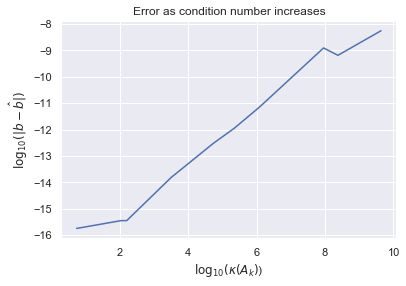

In [10]:
plt.plot(np.log10(condition_numbers), np.log10(errors))
plt.xlabel("$\log_{10}(\kappa(A_k)$)")
plt.ylabel("$\log_{10}(|b - \hat{b}|)$")
plt.title("Error as condition number increases");

As we can see, as we dealt with matrices with higher condition numbers, the inaccuracy of our results tended to grow, as expected.

# Stability of Eigenvalues

If a $n \times n$ matrix $A$ has $n$ linearly independent eigenvectors $(v_1,...,v_n)$ with corresponding eigenvalues $(\lambda_1, ... , \lambda_n)$, then we can diagonlize $A$ as $VDV^{-1}$ where the $i$th column of $V$ is $v_i$ and $D$ is a diagonal matrix with $D_{ii} = \lambda_i$. It turns out that condition number of $V$ can help us understand the stability of computing eigenvalues with the following remarkable theorem

<hr>

**Theorem (Bauer-Fike)**: Let $A \in \mathbb{C}^{n \times n}$ be a diagonlizable matrix such that $A=VDV^{-1}$ (where $V$ is a matrix of eigenvectors and $D$ is a diagonal matrix of corresponding eigenvalues) and $E \in \mathbb{C}^{n \times n}$. If $\mu$ is an eigenvalue of $A + E$ then there exists an eigenvalue of $A$, denoted $\lambda$, such that

$$|\mu - \lambda| \leq \kappa(V) ||E|| $$

<br>
<hr>

This tells us that if we perturb a matrix a little bit, the eigenvalues of the resulting matrix will be close to the original matrix. We will explore and test this theorem more in the next section.

# Eigenvector Condition Number

Define $A$ as follows

$$A = \begin{bmatrix}
    1 & 0  \\
    -1 & 2 
\end{bmatrix} $$ 

which has the following eigenpairs

$$\left(\begin{bmatrix} 0 \\ 1 \end{bmatrix}, 2 \right) \ , \ \left(\begin{bmatrix} 1 \\ 1 \end{bmatrix}, 1 \right)$$

<br>

and thus can be decomposed as 

$$A = 
\begin{bmatrix}
    0 & 1  \\
    1 & 1 
\end{bmatrix} 
\begin{bmatrix}
    2 & 0  \\
    0 & 1 
\end{bmatrix}
\begin{bmatrix}
    0 & 1  \\
    1 & 1 
\end{bmatrix}^{-1}$$

<br>

We can verify our decomposition using Python

In [11]:
A = np.array([[1,0],[-1,2]])
V = np.array([[0,1], [1,1]])
D = np.array([[2,0], [0,1]])
np.all(V @ D @ np.linalg.inv(V) == A)

True

As we know from the Bauer-Fike theorem, the condition number of $V$ is useful for determining the stability of eigenvalues

In [12]:
np.linalg.cond(V)

2.6180339887498953

The issue is that the choice of which eigenvectors to use for creating $V$ is not unique and could effect it's condition number. For example, we can define $V'$ as follows

$$V' = \begin{bmatrix}
    0 & 1  \\
    3 & 1 
\end{bmatrix} $$

<br>

we verify that we can diagonlize $A$ with $V'$ below

In [13]:
V_prime = np.array([[0,1], [3,1]])
np.all(V_prime @ D @ np.linalg.inv(V_prime) == A)

True

However, $\kappa(V) \neq \kappa(V')$

In [14]:
np.linalg.cond(V_prime)

3.3699240762154807

Thus in order to study the condition numbers of diagonlizing matricies, we define the Eigenvector Condition Number as follows

<hr>

**Definition**: The Eigenvector Condition Number of a diagonlizable matrix $A$, denoted $\kappa_V(A)$, is defined as 

$$\kappa_V(A) = \inf_{V:A=VDV^{-1}} \kappa(V) $$


<br>
<hr>

The eigenvector condition number of a matrix is important because it provides the tighestest bound for the inequality in the Bauer-Fike Theorem. There is no known general procedure for computing the eigenvector condition number, however it can sometimes be obvious. For example, if a matrix $A$ is normal, then it can be diagonalized by a unitary matrix. Since unitary matrices are isometries, their condition number is 1. Since a condition number cannot be lower than one, it follows that the eigenvector condition number of $A$ is 1. 